In [1]:
import lal
lal.__version__

'7.2.4'

In [2]:
import torch
torch.__version__

'1.12.1+cu113'

In [9]:
from torch.utils.data import Dataset

loss 0.0007, train acc 0.990, test acc 1.000
1451.7 examples/sec on cuda


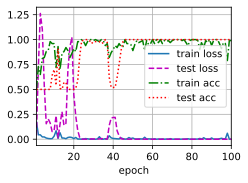

In [2]:
from main import DatasetGenerator
from torch.utils.data import DataLoader
import torch
from main import load_model
from main import train

# 初始化数据生成 class
nsample_perepoch = 100  # 每个epoch的样本数
dataset_train = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 训练数据集
dataset_test = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 测试数据集

# 创建一个DataLoader
data_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)  # 训练数据加载器
test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)  # 测试数据加载器

device = torch.device('cuda')  # 使用CUDA设备

# 模型和损失历史的输出路径
checkpoint_dir = './checkpoints_cnn/'

# 创建模型    
net, epoch, train_loss_history = load_model(checkpoint_dir)  # 加载模型
net.to(device);  # 将模型转移到设备上

# 优化器参数
lr = 0.003  # 学习率
total_epochs = 100  # 总的训练轮数
total_epochs += epoch  # 加上已经训练过的轮数
output_freq = 1  # 输出频率

# 训练模型
train(net, lr, nsample_perepoch, epoch, total_epochs,
      dataset_train, data_loader, test_iter,
      train_loss_history, checkpoint_dir, device, notebook=True)

In [3]:
import lal  
from main import *
from utils import *
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    y_list = []  # 初始化标签列表
    with torch.no_grad():  # 不进行梯度计算
        for X, y in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y = y.to(device).to(torch.long)  # 将标签转移到设备上并转换为长整型
            y_hat = net(X)  # 使用模型进行预测

            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            labels = y.cpu().numpy().tolist()  # 将标签转换为列表

            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
            y_list.extend(labels)  # 将标签添加到标签列表
    return np.asarray(y_hat_list), np.asarray(y_list)  # 返回预测结果和标签的numpy数组```

In [4]:
nsample_perepoch = 1000 # num of injections
snr = 20  # 信噪比

dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch)
data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)

GPU available? True


In [5]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e99.pt


In [6]:
y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

In [7]:
fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
auc = roc_auc_score(y_list, y_hat_list)
auc

0.999356

In [8]:
index = np.argmax(thresholds < 0.5)

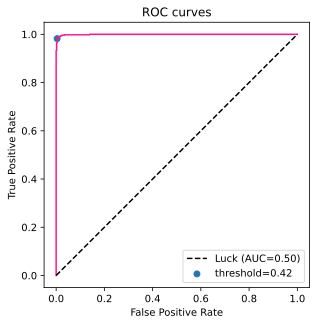

In [9]:
plt.plot(fpr, tpr, color="deeppink")
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
plt.scatter(fpr[index], tpr[index], label=f'threshold={thresholds[index]:.2f}')
plt.axis("square")
# plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 4/4 [00:34<00:00,  8.57s/it]


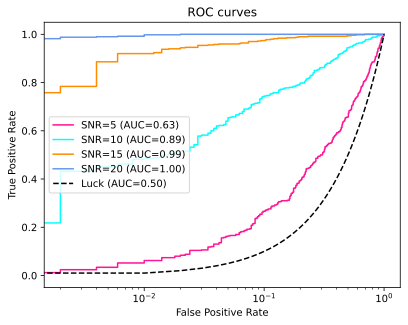

In [10]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

nsample_perepoch = 1000
snr_list = [5, 10, 15, 20]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    plt.plot(fpr, tpr, color=next(colors), label=f'SNR={snr} (AUC={auc:.2f})')
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 3/3 [00:26<00:00,  8.71s/it]


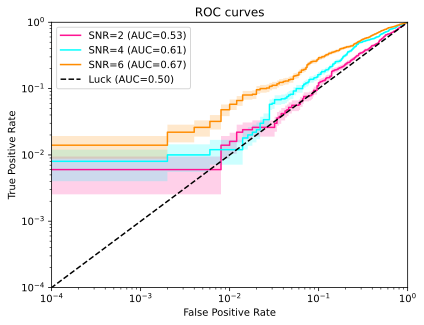

In [11]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

def sigma(n, tp):
    """

    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

nsample_perepoch = 1000
snr_list = [2, 4, 6]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, _ = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    fpr_error = [sigma(len(y_list)/2., t) for t in fpr]
    tpr_error = [sigma(len(y_list)/2., t) for t in tpr]
    
    color = next(colors)
    plt.plot(fpr, tpr, color=color, label=f'SNR={snr} (AUC={auc:.2f})')
    plt.fill_between(fpr, tpr+tpr_error, tpr-tpr_error, alpha=0.2, facecolor=color, zorder=0)
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.legend()
plt.show()

In [43]:
import lal
import _pickle as pickle
from tqdm import tqdm
from main import *
from utils import *

In [46]:
import h5py

def print_hdf5_structure(h5file, indent=0):
    """递归打印 HDF5 文件的结构"""
    for key in h5file.keys():
        obj = h5file[key]
        print("  " * indent + obj.name)
        if isinstance(obj, h5py.Group):
            print_hdf5_structure(obj, indent + 1)
        else:
            print("  " * indent + f"  Shape: {obj.shape}")

test_data_addr = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
with h5py.File(test_data_addr, 'r') as h5file:
    print_hdf5_structure(h5file)

/meta
  /meta/Description
    Shape: ()
  /meta/DescriptionURL
    Shape: ()
  /meta/Detector
    Shape: ()
  /meta/Duration
    Shape: ()
  /meta/GPSstart
    Shape: ()
  /meta/Observatory
    Shape: ()
  /meta/Type
    Shape: ()
  /meta/UTCstart
    Shape: ()
/quality
  /quality/detail
  /quality/injections
    /quality/injections/InjDescriptions
      Shape: (5,)
    /quality/injections/InjShortnames
      Shape: (5,)
    /quality/injections/Injmask
      Shape: (32,)
  /quality/simple
    /quality/simple/DQDescriptions
      Shape: (7,)
    /quality/simple/DQShortnames
      Shape: (7,)
    /quality/simple/DQmask
      Shape: (32,)
/strain
  /strain/Strain
    Shape: (131072,)


In [1]:
import lal
import _pickle as pickle
from tqdm import tqdm
from main import *
from utils import *

def evaluate_submissoin_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    with torch.no_grad():  # 不进行梯度计算
        for X in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y_hat = net(X)  # 使用模型进行预测
            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
    return y_hat_list

In [2]:
test_dataset = np.load('test.npy')
test_dataset.shape

(1200, 1, 2, 16384)

In [3]:
data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

In [4]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e99.pt


In [5]:
results = evaluate_submissoin_gpu(net, data_loader, device)
len(results)

1200

In [6]:
import pandas as pd
pd.DataFrame({'id': range(len(results)),
              'target': results}, index=None).to_csv('submission123.csv', index=False)